In [27]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [28]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [29]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [30]:
# settings
MODEL = "yolov8x.pt"

from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [31]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - person
CLASS_ID = [0]


0: 384x640 27 persons, 4 cars, 1 bus, 2 traffic lights, 1 handbag, 15.8ms
Speed: 2.0ms preprocess, 15.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Detections shape:
Number of persons: 27


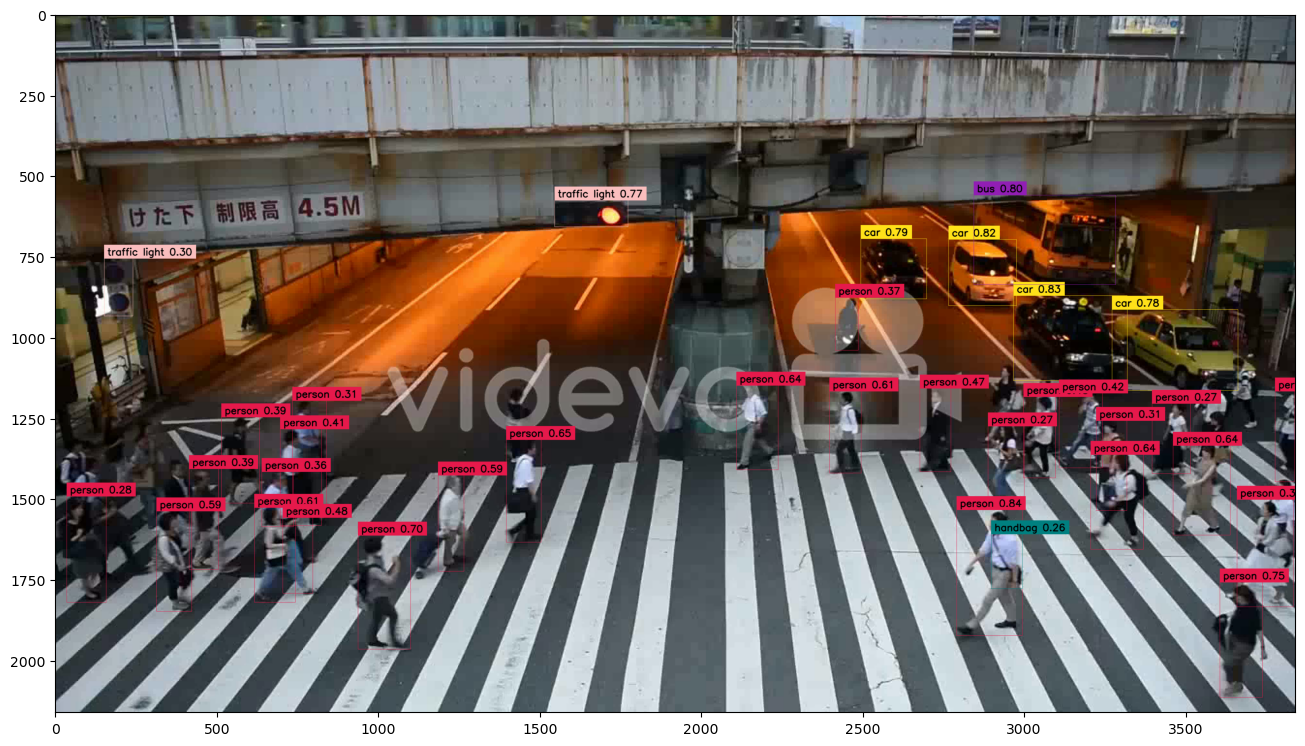

In [32]:
SOURCE_VIDEO_PATH = "./pedestrian/istock-994680554_preview-resized.mp4"
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=2, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)


print("Detections shape:")
number_of_persons = 0
for _, confidence, class_id, tracker_id in detections :
    if(class_id == 0):
        number_of_persons += 1
    # print(f"  {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}")
print(f"Number of persons: {number_of_persons}")

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [33]:
# settings
LINE_START = Point(1800, 0)
LINE_END = Point(1800, 2880)

TARGET_VIDEO_PATH = "./pedestrian/istock-994680554_preview-result.mp4"

In [34]:
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [35]:
video_info.width

3840

In [36]:
# set the line start and end according the orientation of line and video height and width
line_orientation = "vertical"
LINE_START = Point(0, 0)
LINE_END = Point(0, 0)

video_width = video_info.width
video_height = video_info.height

if(line_orientation == "vertical"):
    LINE_START = Point(video_width / 2, 0)
    LINE_END = Point(video_width / 2, video_height)
elif(line_orientation == "horizontal"):
    LINE_START = Point(0, video_height / 2)
    LINE_END = Point(video_width, video_height / 2)

print(f"Line start: {LINE_START}")
print(f"Line end: {LINE_END}")

Line start: Point(x=1920.0, y=0)
Line end: Point(x=1920.0, y=2160)


In [37]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'


In [38]:
from custom_line_counter import CustomLineCounterAnnotator, CustomLineCounter

In [39]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineCounter instance
line_counter = CustomLineCounter(start=LINE_START, end=LINE_END, line_orientation=line_orientation)
# line_counter = LineCounter(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

line_annotator = CustomLineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
# line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    frame_counter = 0
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        frame_counter += 1

        # Check if 100 frames have been processed
        # if frame_counter >= 100:
        #     break
        
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/312 [00:00<?, ?it/s]


0: 384x640 27 persons, 4 cars, 1 bus, 2 traffic lights, 1 handbag, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 4 cars, 1 bus, 1 traffic light, 1 handbag, 14.9ms
Speed: 1.1ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 4 cars, 1 bus, 1 traffic light, 1 handbag, 14.8ms
Speed: 1.2ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 4 cars, 1 bus, 1 traffic light, 1 handbag, 14.2ms
Speed: 1.6ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 4 cars, 1 bus, 1 traffic light, 1 suitcase, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 4 cars, 1 bus, 1 traffic light, 1 backpack, 1 handbag, 1 suitcase, 14.2ms
Speed: 1.7ms preprocess, 14.2ms inference, 1.